# Setup

In [1477]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            #.config('spark.master', "local")
            .config('spark.master', "local[12]")
            #.config('spark.master', "local[24]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Find the best "dippers"

In [1395]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('wtf_full_oct19_6')

In [1470]:
import importlib
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [1398]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r'],
            wtf['mjd_i'],
            wtf['mag_i'],
            wtf['magerr_i'],
            wtf['xpos_i'],
            wtf['ypos_i'],
            wtf['catflags_i'],
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        # & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        #& (sparkfunc.col("dip.significant_width") >= 0.5)
        & (sparkfunc.col("dip.significance") >= 10)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
    )
)

In [1471]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    #.drop('dip')
    .select(
        '*',
    )
    .where(
        #(sparkfunc.col("dip.significant_observation_count") >= 3)
        #(sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        #(sparkfunc.col("dip.significant_width") >= 0.5)
        (sparkfunc.col("dip.significance") >= 20)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        #(sparkfunc.col("dip.max_gap_fraction") < 0.8)
    )
)

In [1472]:
aa = rescored_wtf.head(100)

In [1456]:
%matplotlib notebook

<IPython.core.display.Javascript object>


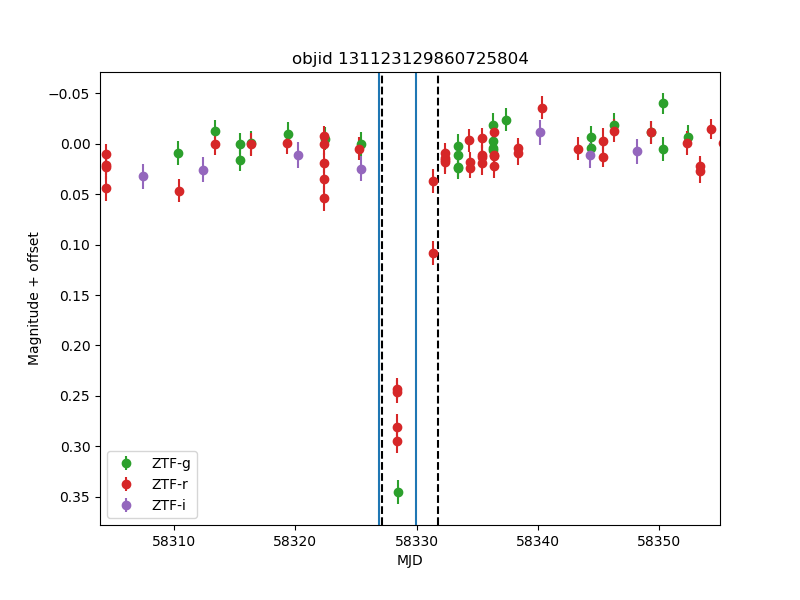

In [1476]:
idx = 0
dipper.plot_light_curve(aa[idx], parsed=True, verbose=False, zoom=True)
z = dipper.measure_dip_row(aa[idx])
plt.axvline(z['start_mjd'])
plt.axvline(z['end_mjd'])

In [1399]:
%%time

# Get the best dippers
print(f"Initial dataset: {wtf.count()} light curves.")
#best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).head(1000)
best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).collect()
print(f"Found {len(best_dippers)} dippers")

Initial dataset: 88092 light curves.
Found 0 dippers
CPU times: user 216 ms, sys: 167 ms, total: 384 ms
Wall time: 5min 1s


In [1403]:
%matplotlib inline

In [1409]:
# Plot a light curve
for i in range(10):
    dipper.plot_light_curve(best_dippers[i], verbose=False, zoom=True)
    #dipper.plot_dip(best_dippers[i])

IndexError: list index out of range

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


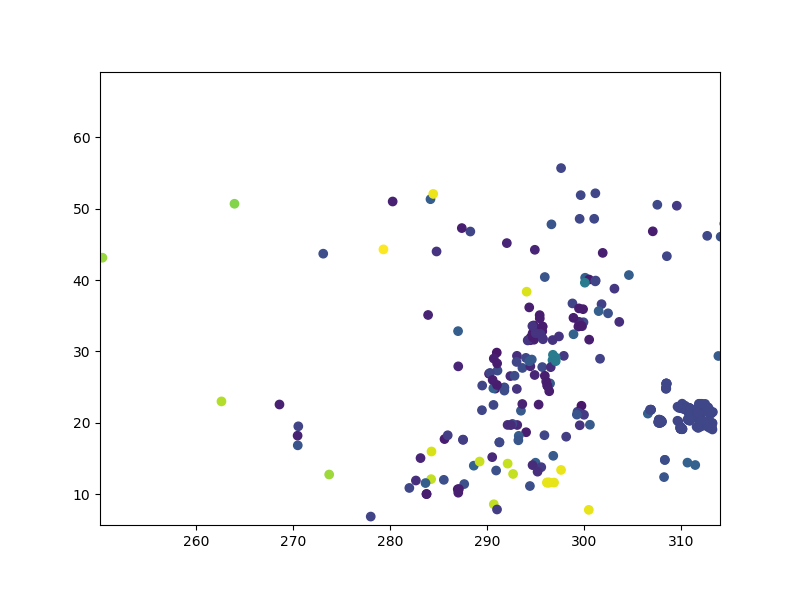

In [52]:
ra = np.array([i['ra'] for i in best_dippers])
dec = np.array([i['dec'] for i in best_dippers])
mjd = np.array([i['dip']['center_mjd'] for i in best_dippers])
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(ra, dec, c=mjd)

In [26]:
import pandas as pd
df = pd.DataFrame([i.asDict() for i in best_dippers])

In [25]:
best_dippers[0].asDict()

{'objid': 84772845093064935,
 'ra': 284.50932277976193,
 'dec': -19.354513106547607,
 'mean_mag_g': 14.871501445770264,
 'mean_mag_r': 14.696561066501111,
 'mean_mag_i': None,
 '_debug_first_ra': 284.5093165,
 '_debug_first_dec': -19.3545132,
 'ps1_gMeanPSFMag': 14.7668,
 'ps1_rMeanPSFMag': 14.6095,
 'ps1_iMeanPSFMag': 14.5762,
 'mjd_g': [58728.164317111106, 58757.14646991111],
 'mag_g': [15.032293319702148, 14.710709571838379],
 'magerr_g': [0.01608196459710598, 0.01580357551574707],
 'psfflux_g': [26467.806640625, 38720.765625],
 'psffluxerr_g': [489.9927978515625, 506.4166259765625],
 'catflags_g': [0, 0],
 'expid_g': [97416414, 100314629],
 'xpos_g': [691.52197265625, 707.5369873046875],
 'ypos_g': [1022.8200073242188, 1063.134033203125],
 'nobs_g': 2,
 'mjd_r': [58305.3548611,
  58694.235532411105,
  58665.302881911106,
  58703.21798611111,
  58718.244074111106,
  58694.23598381111,
  58665.30333331111,
  58703.21843751111,
  58718.245520811106,
  58694.287141211105,
  58665.32130

In [33]:
df['dip'][0]['center_mjd']

58725.31640625

In [55]:
np.sum(weird_mask)

340

In [53]:
weird_mask = (ra > 307) & (ra < 314) & (dec > 19) & (dec < 23)

<IPython.core.display.Javascript object>


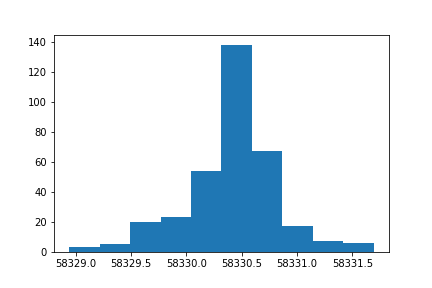

(array([  3.,   5.,  20.,  23.,  54., 138.,  67.,  17.,   7.,   6.]),
 array([58328.94140625, 58329.21640625, 58329.49140625, 58329.76640625,
        58330.04140625, 58330.31640625, 58330.59140625, 58330.86640625,
        58331.14140625, 58331.41640625, 58331.69140625]),
 <a list of 10 Patch objects>)

In [54]:
plt.figure()
plt.hist(mjd[weird_mask])

RA+Dec: 311.782921+21.533159

Dip details:
integral   : 0.6099096536636353
integral_uncertainty: 0.03722697123885155
significance: 16.383543014526367
start_mjd  : 58327.30078125
center_mjd : 58330.46875
end_mjd    : 58331.6875
length     : 4.38621711730957
max_gap    : 2.9334142208099365
max_gap_fraction: 0.6687799692153931
window_start_mjd: 58326.3359375
dip_observation_count: 4
significant_observation_count: 3
core_not_significant_fraction: 0.0
significant_width: 2.928657293319702
ref_observation_count: 361
ref_pull_std: 1.1433324813842773
ref_large_pull_fraction: 0.011080332100391388


<IPython.core.display.Javascript object>


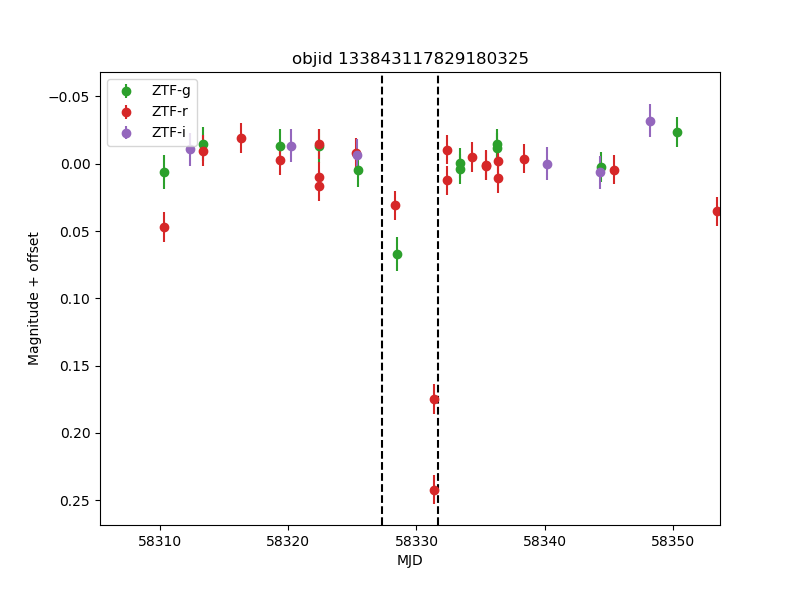

In [49]:
dipper.plot_light_curve(best_dippers[np.where(weird_mask)[0][6]], zoom=True)

In [ ]:
# Show an interactive display of the light curves
dipper.plot_interactive(best_dippers)

# Rerun over the full ZTF dataset

Warning! This takes a long time to run. With the latest dipper code, it is ~2000 core hours. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. It is also possible to run on AWS with hundreds or even thousands of cores.

In [364]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

In [ ]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r'],
            ztf['mjd_i'],
            ztf['mag_i'],
            ztf['magerr_i'],
            ztf['xpos_i'],
            ztf['ypos_i'],
            ztf['catflags_i']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.2)
        & (sparkfunc.col("dip.max_gap") < 3.)
    )
    .write.parquet('./query_wtf_7.parquet')
)

In [ ]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('./query_wtf_7.parquet')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_6', repartition=True)

In [62]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('../../edata/ztf_boyajian/s3_test_wtf/')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_6', repartition=True)

# Tests of the dipper finder on simulations

In [886]:
def simulate_light_curve(N=1000, err=0.01, width=5, depth=0.2):
    x = np.sort(np.random.uniform(0, 1000, N))
    y = np.random.normal(size=N) * err
    yerr = np.ones(N) * err
    y += depth * np.exp(-(x-500)**2 / 2 / width**2)
    #y += depth * np.exp(-(x-525)**2 / 2 / width**2)
    
    return x, y, yerr

In [1209]:
import importlib
import dipper
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [888]:
def measure_dip(x, y, yerr):
    bin_edges = np.hstack([0, (x[1:] + x[:-1]) / 2., 1000])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    wf = y * bin_widths
    ws2 = bin_widths**2 * yerr**2
    sig = y / yerr

    integral = np.zeros((len(x), len(x)))
    intvar = np.zeros((len(x), len(x)))
    numsig = np.zeros((len(x), len(x)), dtype=int)

    for i in range(len(x)):
        if i != 0:
            integral[i] = integral[i-1]
            intvar[i] = intvar[i-1]
            numsig[i] = numsig[i-1]

        integral[i, :i+1] += wf[i]
        intvar[i, :i+1] += ws2[i]
        if sig[i] >= 3:
            numsig[i, :i+1] += 1
            
    
    intvar[intvar == 0] = 1
    significance = integral / np.sqrt(intvar)
    end_idx, start_idx = np.unravel_index(np.argmax(significance), significance.shape)
    start = bin_edges[start_idx]
    end = bin_edges[end_idx+1]
    max_significance = significance[end_idx, start_idx]
    print(start, end, max_significance)
    
    mask = numsig < 3
    integral[mask] = 0
    intvar[mask] = 1
    #intvar[intvar == 0] = 1
    
    significance = integral / np.sqrt(intvar)
    end_idx, start_idx = np.unravel_index(np.argmax(significance), significance.shape)
    start = bin_edges[start_idx]
    end = bin_edges[end_idx+1]
    max_significance = significance[end_idx, start_idx]
    print(start, end, max_significance)
    print(np.sum(sig >= 3))

    
    #print(start, end)
    #print(max_significance)
    #res = dipper.measure_dip(x, y, yerr)
    #print(res['significance'])
    
    return start, end

In [1225]:
x, y, yerr = simulate_light_curve(50)

In [1226]:
%%timeit

res = dipper.measure_dip(x, y, yerr, min_significant_count=1, significant_threshold=2)

176 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>


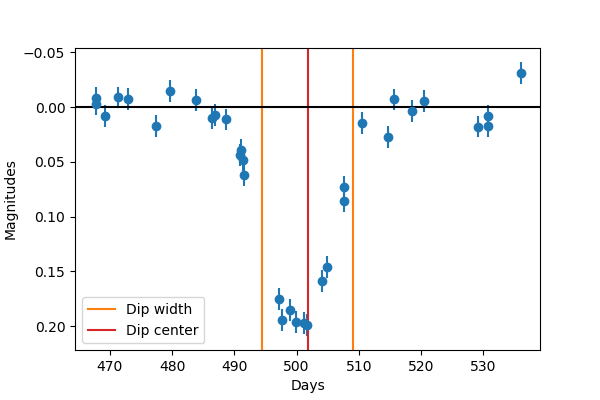

<IPython.core.display.Javascript object>


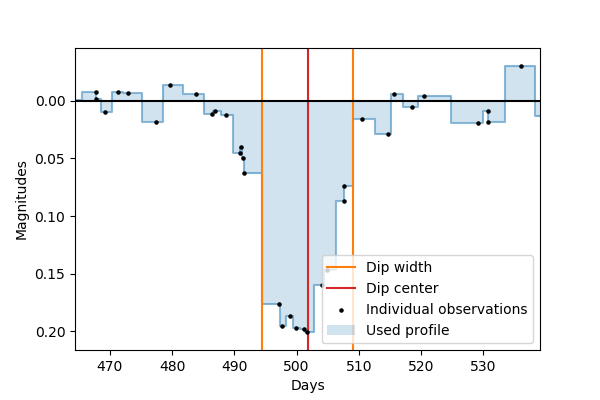

{'integral': 2.352673942294741,
 'integral_uncertainty': 0.05021608506330971,
 'significance': 46.85100280773815,
 'start_mjd': 494.38446191338323,
 'center_mjd': 501.75850573435633,
 'end_mjd': 509.13254955532943,
 'length': 14.7480876419462,
 'max_gap': 5.566785133303654,
 'max_gap_fraction': 0.37745809954849474,
 'ref_observation_count': 382,
 'ref_pull_std': 0.9442755908241842,
 'ref_large_pull_fraction': 0.002617801047120419,
 'dip_observation_count': 10,
 'significant_observation_count': 10,
 'core_not_significant_fraction': 0.0,
 'significant_width': 10.512626889139767}

In [1119]:
# Basic sim
x, y, yerr = simulate_light_curve(400)
#x, y, yerr = simulate_light_curve(400, err=0.05)

res = dipper.measure_dip(x, y, yerr)

def annotate_plot():
    plt.axvline(res['start_mjd'], c='C1', label='Dip width')
    plt.axvline(res['center_mjd'], c='C3', label='Dip center')
    plt.axvline(res['end_mjd'], c='C1')
    
    plt.axhline(0, c='k')

    plt.xlim(res['start_mjd'] - 30, res['end_mjd'] + 30)
    plt.gca().invert_yaxis()

    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Magnitudes')

plt.figure(dpi=100)
plt.errorbar(x, y, yerr, fmt='o')
annotate_plot()

res_parsed = dipper.measure_dip(x, y, yerr, return_parsed_observations=True)
if len(res_parsed) > 0:
    mjd = res_parsed['parsed_mjd']
    mag = res_parsed['parsed_mag']
    magerr = res_parsed['parsed_magerr']

    plt.figure(dpi=100)
    plt.scatter(mjd, mag, s=5, c='k', zorder=3, label='Individual observations')
    plt.fill_between(mjd, mag, step='mid', alpha=0.2, label='Used profile')
    plt.plot(mjd, mag, drawstyle='steps-mid', alpha=0.5)
    annotate_plot()

res

<IPython.core.display.Javascript object>


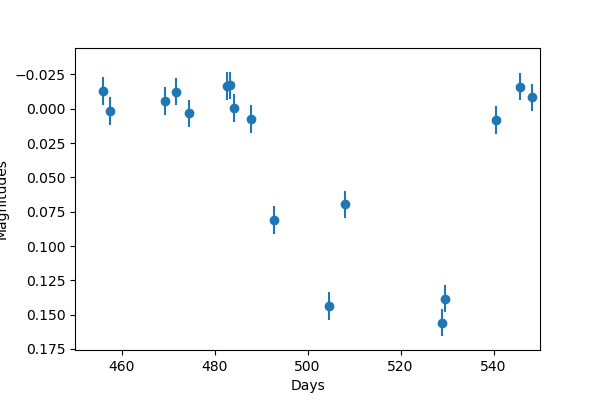

{'integral': 4.885648596968273, 'integral_uncertainty': 0.3889859652277597, 'significance': 12.559961113526603, 'start_mjd': 496.72152553861366, 'center_mjd': 518.9433772316635, 'end_mjd': 533.3908210527024, 'length': 36.66929551408879, 'window_start_mjd': 436.70563484511433, 'window_end_mjd': 592.678765206307, 'max_gap': 20.999570505382508, 'max_gap_fraction': 0.5726745008590148, 'ref_observation_count': 88, 'ref_pull_std': 0.9865212157007406, 'ref_large_pull_fraction': 0.0, 'dip_observation_count': 4, 'significant_observation_count': 4, 'core_not_significant_fraction': 0.0, 'significant_width': 24.92614353920834}


<IPython.core.display.Javascript object>


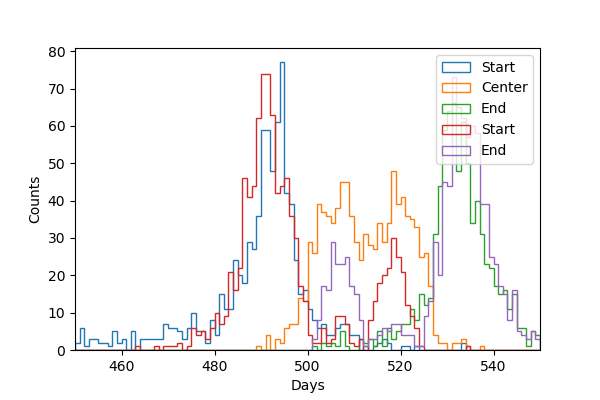

5.0576132207221125


In [574]:
# Simulate a lot of poorly sampled dips, and see how well we recover them.

all_start = []
all_start_2 = []
all_center = []
all_end = []
all_end_2 = []
all_integral = []

for i in range(1000):
    # Basic sim
    x, y, yerr = simulate_light_curve(N=100)
    
    res = dipper.measure_dip(x, y, yerr)
    start, end = measure_dip(x, y, yerr)
    
    if i == 0:
        # Show the first light curve
        plt.figure(dpi=100)
        plt.errorbar(x, y, yerr, fmt='o')
        plt.gca().invert_yaxis()
        plt.xlim(450, 550)
        plt.xlabel('Days')
        plt.ylabel('Magnitudes')
        print(res)
        
    all_start_2.append(start)
    all_end_2.append(end)
    #all_center.append(0)
    #all_integral.append(0)

    all_start.append(res['start_mjd'])
    all_center.append(res['center_mjd'])
    all_end.append(res['end_mjd'])
    all_integral.append(res['integral'])
    
plt.figure(dpi=100)
plt.hist(all_start, 100, (450, 550), histtype='step', label='Start')
plt.hist(all_center, 100, (450, 550), histtype='step', label='Center')
plt.hist(all_end, 100, (450, 550), histtype='step', label='End')
plt.hist(all_start_2, 100, (450, 550), histtype='step', label='Start')
plt.hist(all_end_2, 100, (450, 550), histtype='step', label='End')
plt.xlim(450, 550)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.legend()
print(np.mean(all_integral))

# Select a random subset of light curves

In [7]:
%%time

# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

# Number of light curves to target
N = 100000

base_sample = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
)

count = base_sample.count()
frac = N / count

# Run the dip detection query on the full ZTF dataset on spark
result = (
    base_sample
    .sample(False, frac)
    .select(
        ztf['mjd_g'],
        ztf['mag_g'],
        ztf['magerr_g'],
        ztf['mjd_r'],
        ztf['mag_r'],
        ztf['magerr_r'],
        ztf['mjd_i'],
        ztf['mag_i'],
        ztf['magerr_i'],
    )
    .write.mode('overwrite').parquet('./sample_lightcurves.parquet')
)

CPU times: user 2.21 s, sys: 611 ms, total: 2.82 s
Wall time: 2h 39min 1s


In [1168]:
df = pd.read_parquet('./sample_lightcurves.parquet')

<IPython.core.display.Javascript object>


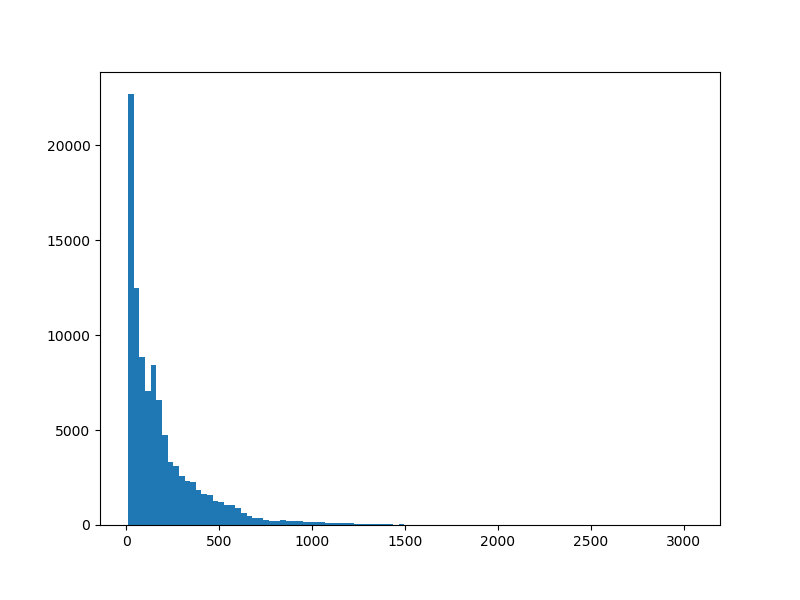

127.0


In [1176]:
plt.figure(figsize=(8, 6), dpi=100)
count_g = np.array([len(i) for i in df['mjd_g']])
count_r = np.array([len(i) for i in df['mjd_r']])
count_i = np.array([len(i) for i in df['mjd_i']])
count = count_g + count_r + count_i

plt.hist(count, 100)
print(np.median(count))